In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from imutils import paths
import cv2
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("driver_imgs_list.csv")
classes = df.classname.unique()

In [3]:
Dict = {}
j=0
for i in classes:
    Dict[i]=j
    j=j+1

In [4]:
X = []
Y = []
train_path='C:/Users/HITESHWAR SINGH/Desktop/Technocolabs/Dataset/imgs/train'

In [5]:
for label in classes:
    path = os.path.join(train_path , label)
    for img in os.listdir(path):
        img = cv2.imread(os.path.join(path,img))
        new_img = cv2.resize(img, (64, 128))
        X.append(new_img)
        Y.append(Dict[label])

In [7]:
np.save("TrainingData",X)
np.save("TargetData",Y)

In [2]:
X = np.load("TrainingData.npy")
Y = np.load("TargetData.npy")

In [3]:
X=np.array(X)
Y=np.array(Y)
print(X.shape)
print(Y.shape)

(22424, 128, 64, 3)
(22424,)


In [23]:
from sklearn.model_selection import train_test_split
X_train,x_test,Y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=1)
X_test,X_val,Y_test,Y_val = train_test_split(x_test,y_test, test_size=0.1, random_state=1)


In [24]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(15696, 128, 64, 3)
(15696,)
(6055, 128, 64, 3)
(6055,)
(673, 128, 64, 3)
(673,)


In [16]:
np.save("TrainingData.csv",X)
np.save("TargetData",Y)

## Hog Feature Extraction

In [25]:
from skimage.feature import hog
def get_hog(images, name='hog', save=False):
    result = np.array([hog(img, block_norm='L2',
                        orientations=9,
                        pixels_per_cell=(8, 8), 
                        cells_per_block=(3, 3)) 
                        for img in images])
    return result

In [26]:

hog_train = get_hog(X_train, name='hog_train', save=True)
hog_val = get_hog(X_val, name='hog_val', save=True)


In [27]:
# np.save("HOG_Training Data",hog_train)
# np.save("HOG_ Validation Data",hog_val)

In [28]:
# hog_train = np.load("HOG_Training Data.npy")
# hog_val = np.load("HOG_ Validation Data.npy")

In [29]:
print(hog_train.shape)
print(Y_train.shape)
print(hog_val.shape)
print(Y_val.shape)


(15696, 6804)
(15696,)
(673, 6804)
(673,)


## Normalization

In [30]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(hog_train)
norm_hog_train = min_max_scaler.transform(hog_train)
norm_hog_val = min_max_scaler.transform(hog_val)

In [31]:
print(norm_hog_train.shape)
print(norm_hog_val.shape)

(15696, 6804)
(673, 6804)


In [23]:
with open('norm_dump.pkl', 'wb') as pickle_file:
        pickle.dump(min_max_scaler, pickle_file)

## PCA

In [32]:
from sklearn.decomposition import PCA
pca=PCA(n_components=100)
pca.fit(norm_hog_train)
pca_norm_hog_train = pca.transform(norm_hog_train)
pca_norm_hog_val = pca.transform(norm_hog_val)

In [25]:
with open('pca_dump.pkl', 'wb') as pickle_file:
        pickle.dump(pca, pickle_file)

In [1]:
pca_reload = pickle.load(open("pca_dump.pkl",'rb'))

In [19]:
pca_norm_hog_train = pca_reload.transform(norm_hog_train)
pca_norm_hog_val = pca_reload.transform(norm_hog_val)


In [33]:
print(pca_norm_hog_train.shape)
print(pca_norm_hog_val.shape)

(15696, 100)
(673, 100)


In [34]:
from sklearn.svm import SVC
model_pca = SVC()
model_pca.fit(pca_norm_hog_train, Y_train)
accPCA = model_pca.score(pca_norm_hog_val,Y_val)


In [35]:
trainAcc = model_pca.score(pca_norm_hog_train,Y_train)

In [36]:
print("Accuracy on Training Set: ",round(trainAcc,5)*100,"%")

Accuracy on Training Set:  99.541 %


In [37]:
print("Accuracy on Validation: ",round(accPCA,5)*100,"%")

Accuracy on Validation:  99.10799999999999 %


In [38]:
hog_test= get_hog(X_test, name='hog_test', save=True)
print(hog_test.shape)

(6055, 6804)


In [40]:
norm_hog_test = min_max_scaler.transform(hog_test)
print(norm_hog_test.shape)

(6055, 6804)


In [41]:
pca_norm_hog_test = pca.transform(norm_hog_test)
print(pca_norm_hog_test.shape)

(6055, 100)


In [42]:
testingAcc = model_pca.score(pca_norm_hog_test,Y_test)

In [43]:
print("Accuracy on testset: ",round(testingAcc,6)*100,"%")

Accuracy on testset:  99.3394 %


In [45]:
Y_pred = model_pca.predict(pca_norm_hog_test)

In [36]:
with open('model_pca_dump.pkl', 'wb') as pickle_file:
        pickle.dump(model_pca, pickle_file)

## LDA

In [50]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# lda = LDA(n_components=9)
# lda_norm_hog_train = lda.fit_transform(norm_hog_train,Y_train)
# lda_norm_hog_val = lda.transform(norm_hog_val)

In [51]:
# print(lda_norm_hog_train.shape)
# print(lda_norm_hog_val.shape)

(15696, 9)
(3364, 9)


In [52]:
# model_lda = SVC()
# model_lda.fit(lda_norm_hog_train, Y_train)
# accLDA=model_lda.score(lda_norm_hog_val,Y_val)
# print("Accuracy on LDA: ",round(accLDA,5)*100,"%")

Accuracy on LDA:  99.614 %


In [56]:
# acctrain=model_lda.score(lda_norm_hog_train,Y_train)
# print("Accuracy on LDA: ",round(acctrain,5)*100,"%")

Accuracy on LDA:  99.994 %


In [53]:
# lda_norm_hog_test = lda.transform(norm_hog_test)
# print(lda_norm_hog_test.shape)

(3364, 9)


In [54]:
# testingAcclda = model_lda.score(lda_norm_hog_test,Y_test)

In [55]:
print("Accuracy on testset: ",round(testingAcclda,5)*100,"%")

Accuracy on testset:  99.673 %


## LDA over PCA

In [30]:
# lda_pca = LDA(n_components=9)
# lda_pca_norm_hog_train = lda_pca.fit_transform(pca_norm_hog_train,Y_train)
# lda_pca_norm_hog_val = lda_pca.transform(pca_norm_hog_val)

In [31]:
# print(lda_pca_norm_hog_train.shape)
# print(lda_pca_norm_hog_val.shape)

(16145, 9)
(1794, 9)


In [32]:
# model_lda_o_pca = SVC()
# model_lda_o_pca.fit(lda_pca_norm_hog_train, Y_train)
# acc_lda_o_pca = model_lda_o_pca.score(lda_pca_norm_hog_val,Y_val)

In [33]:
# print("Accuracy on Validation: ",round(acc_lda_o_pca,5)*100,"%")

Accuracy on Validation:  90.412 %


In [34]:
# lda_pca_norm_hog_test = lda_pca.transform(pca_norm_hog_test)
# print(lda_pca_norm_hog_test.shape)

(4485, 9)


In [35]:
# acc_lda_o_pca = model_lda_o_pca.score(lda_pca_norm_hog_test,Y_test)

In [36]:
# print("Accuracy on Validation: ",round(acc_lda_o_pca,5)*100,"%")

Accuracy on Validation:  91.327 %


# Single Image Results

In [42]:
pca_reload = pickle.load(open("pca_dump.pkl",'rb'))
norm_reload = pickle.load(open("Norm_dump.pkl",'rb'))
model = pickle.load(open("model_pca_dump.pkl",'rb'))

(22424, 128, 64, 3)
Time taken to predict one image:  0.16752910614013672
5


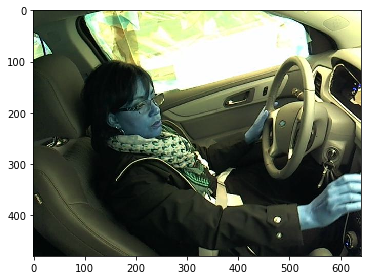

In [50]:
path='C:/Users/HITESHWAR SINGH/Desktop/Technocolabs/Dataset/imgs/test/img_1.jpg'

Xv=[]
img = cv2.imread(path)
new_img = cv2.resize(img, (64, 128))
Xv.append(new_img)
Xv=np.array(Xv)

print(X.shape)

ti = time()
imshow(img)
hog_input = get_hog(Xv, name='hog_train', save=True)

norm_hog_input = norm_reload.transform(hog_input)
pca_norm_hog_train = pca_reload.transform(norm_hog_input)
driver_pred = model.predict(pca_norm_hog_train)
print("Time taken to predict one image: ",time()-ti)
print(int(driver_pred[0]))

In [40]:
# c0: safe driving
# c1: texting - right
# c2: talking on the phone - right
# c3: texting - left
# c4: talking on the phone - left
# c5: operating the radio
# c6: drinking
# c7: reaching behind
# c8: hair and makeup
# c9: talking to passenger

# PLOT GENERATION

In [72]:
# X_hog = get_hog(X, name='hog_train', save=True)
# print(X_hog.shape)

(22424, 6804)


(22424, 6804)
(22424, 100)


In [ ]:
# print(X_pca_norm_hog.shape)

In [77]:
# np.save("Alldatahoged",X_hog)

In [70]:
# from sklearn.model_selection import learning_curve

In [39]:
# train_size, train_score, test_score = learning_curve(SVC(gamma=0.001),X_pca_norm_hog,Y,cv=5, n_jobs=4,train_sizes=np.linspace(0.01,1,10))

In [40]:
# train_mean = np.mean(train_score,axis=1)

In [52]:
# test_score

array([[       nan,        nan,        nan,        nan,        nan],
       [0.1574136 , 0.15562988, 0.15139353, 0.15005574, 0.15031222],
       [0.27692308, 0.28673356, 0.28383501, 0.28539576, 0.28657449],
       [0.35629877, 0.35629877, 0.36098105, 0.35607581, 0.35526316],
       [0.46956522, 0.47692308, 0.4735786 , 0.46889632, 0.4721231 ],
       [0.60401338, 0.60691193, 0.61070234, 0.60379041, 0.60615522],
       [0.69877369, 0.70167224, 0.70501672, 0.69498328, 0.70026762],
       [0.79108138, 0.79710145, 0.79687848, 0.78952062, 0.79237288],
       [0.85551839, 0.86555184, 0.86109253, 0.85462653, 0.85994648],
       [0.93467113, 0.94046823, 0.94314381, 0.93712375, 0.941124  ]])

In [53]:
# train_score

array([[       nan,        nan,        nan,        nan,        nan],
       [0.96236059, 0.96143123, 0.96003717, 0.96189591, 0.96096654],
       [0.96775758, 0.97163636, 0.96945455, 0.97090909, 0.96872727],
       [0.9499918 , 0.95228726, 0.95195934, 0.95228726, 0.95048369],
       [0.95379088, 0.95081764, 0.95218038, 0.95242815, 0.95230426],
       [0.96923843, 0.96903932, 0.96923843, 0.9705326 , 0.96933798],
       [0.96663616, 0.96713537, 0.96705217, 0.96921541, 0.96771778],
       [0.96991138, 0.97026872, 0.9696255 , 0.97119783, 0.97141224],
       [0.95540244, 0.95502662, 0.95646727, 0.95684309, 0.95659255],
       [0.94537042, 0.9425832 , 0.9435866 , 0.94576063, 0.94386532]])

In [42]:
# test_mean = np.mean(test_score,axis=1)

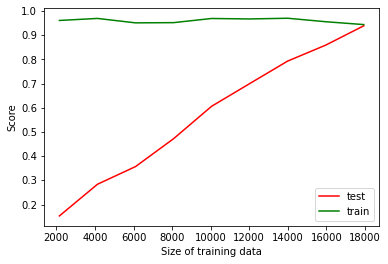

In [49]:
# plt.plot(train_size,test_mean,color='r',label="test")
# plt.plot(train_size,train_mean,color='g',label="train")

# plt.xlabel("Size of training data")
# plt.ylabel("Score")
# plt.legend()
# plt.show()

In [59]:
# from sklearn.tree import DecisionTreeClassifier

In [61]:
# DT_model = DecisionTreeClassifier()
# DT_model.fit(pca_norm_hog_train,Y_train)

DecisionTreeClassifier()

In [66]:
# DT_tr_acc = DT_model.score(pca_norm_hog_train,Y_train)
# print("Accuracy on trainig",DT_tr_acc*100)

Accuracy on trainig 100.0


In [67]:
# DT_vl_acc = DT_model.score(pca_norm_hog_val,Y_val)
# print("Accuracy on Val",DT_vl_acc*100)

Accuracy on Val 80.26159334126041


In [68]:
# DT_tst_acc = DT_model.score(pca_norm_hog_test,Y_test)
# print("Accuracy on trainig",DT_tst_acc*100)

Accuracy on trainig 81.27229488703924


In [78]:
# train_size, train_score, test_score = learning_curve(DecisionTreeClassifier(),X_pca_norm_hog,Y,cv=5, n_jobs=4,train_sizes=np.linspace(0.01,1,10))

In [80]:
# np.save("train_size",train_size)
# np.save("train_score",train_score)
# np.save("test_score",test_score)

In [2]:
# import numpy as np
# train_size = np.load("train_size.npy")
# test_score = np.load("test_score.npy")
# train_score = np.load("train_score.npy")

In [3]:
# test_mean = np.mean(test_score,axis=1)
# train_mean = np.mean(train_score,axis=1)


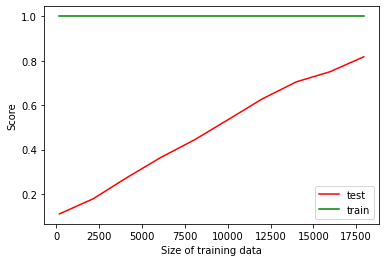

In [5]:
# import matplotlib.pyplot as plt
# plt.plot(train_size,test_mean,color='r',label="test")
# plt.plot(train_size,train_mean,color='g',label="train")

# plt.xlabel("Size of training data")
# plt.ylabel("Score")
# plt.legend()
# plt.show()

In [24]:
# import xgboost as xgb
# xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
# xgb_model.fit(pca_norm_hog_train,Y_train)

C:\Users\HITESHWAR SINGH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[16:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
# xgb_model.score(pca_norm_hog_train,Y_train)

1.0

In [25]:
# xgb_model.score(pca_norm_hog_val,Y_val)

0.9869203329369798

In [31]:
# xgb_model.score(pca_norm_hog_test,Y_test)

0.9875148632580262

In [44]:
from sklearn.metrics import plot_confusion_matrix ,confusion_matrix, precision_score, recall_score, f1_score

In [48]:
precisionRF = precision_score(Y_test,Y_pred,average="macro")
recallRF = recall_score(Y_test,Y_pred,average="macro")
fScoreRF = f1_score(Y_test,Y_pred,average="macro")

In [50]:
print("Precsion: ",round(precisionRF*100,2),"%")
print("Recall: ",round(recallRF*100,2),"%")
print("F Score: ",round(fScoreRF*100,2),"%")

Precsion:  99.34 %
Recall:  99.3 %
F Score:  99.32 %


In [53]:
conMatrix = confusion_matrix(Y_test,Y_pred)
print(conMatrix)

[[693   1   0   0   0   0   0   0   0   0]
 [  0 606   0   0   0   0   0   0   0   0]
 [  0   0 617   0   0   0   2   0   1   0]
 [  3   0   0 624   1   0   0   0   0   0]
 [  0   0   0   0 635   0   0   0   1   0]
 [  6   1   0   0   0 618   0   0   0   0]
 [  0   1   0   0   0   0 648   0   2   0]
 [  0   0   0   0   0   0   0 537   1   0]
 [  1   0   0   0   1   0   1   0 498   7]
 [  3   3   1   2   0   0   0   0   1 539]]


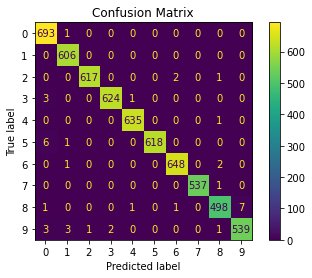

In [54]:
plot_confusion_matrix(model_pca, pca_norm_hog_test, Y_test)
plt.title("Confusion Matrix")
plt.show()

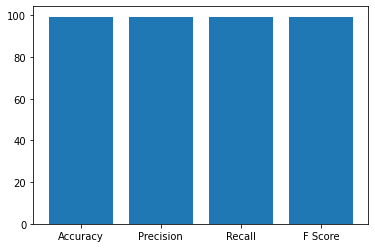

In [56]:
y_label = [testingAcc*100, precisionRF*100,recallRF*100,fScoreRF*100]
x_label = ['Accuracy','Precision','Recall','F Score']

plt.bar(x_label,y_label)
plt.show()